In [ ]:
# Libraries and dependencies
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, matthews_corrcoef, mean_absolute_error

# loading the dataset
store = pd.HDFStore(r'\ukdale.h5')

# Helper function to resample the meter data
def resample_meter(store=None, building=1, meter=1, period='1min', cutoff=1000.):
    key = '/building{}/elec/meter{}'.format(building,meter)
    m = store[key]
    v = m.values.flatten()
    t = m.index
    s = pd.Series(v, index=t).clip(0.,cutoff)
    s[s < 10.] = 0.
    return s.resample('1s').ffill(limit=300).fillna(0.).resample(period).mean().tz_convert('UTC')

# Helper function to get a series from the dataset
def get_series(datastore, house, label, cutoff):
    
    filename = './house_%1d_labels.dat' %house
    labels = pd.read_csv(filename, delimiter=' ', header=None, index_col=0).to_dict()[1]
    
    for i in labels:
        if labels[i] == label:
            s = resample_meter(store, house, i, '1min', cutoff)
    
    s.index.name = 'datetime'
    return s

# Helper function to get status
def get_status(app, threshold, min_off, min_on):
    condition = app > threshold
    d = np.diff(condition)
    idx, = d.nonzero()
    idx += 1

    if condition[0]:
        idx = np.r_[0, idx]
    if condition[-1]:
        idx = np.r_[idx, condition.size]

    idx.shape = (-1,2)
    on_events = idx[:,0].copy()
    off_events = idx[:,1].copy()

    if len(on_events) > 0:
        off_duration = on_events[1:] - off_events[:-1]
        off_duration = np.insert(off_duration, 0, 1000.)
        on_events = on_events[off_duration > min_off]
        off_events = off_events[np.roll(off_duration, -1) > min_off]

        on_duration = off_events - on_events
        on_events = on_events[on_duration > min_on]
        off_events = off_events[on_duration > min_on]

    s = app.copy()
    s[:] = 0.
    for on, off in zip(on_events, off_events):
        s[on:off] = 1.

    return s


In [4]:
# Dataset class for power data
class Power(Dataset):
    def __init__(self, meter=None, appliance=None, status=None, length=256, border=680, max_power=1., train=False):
        self.length = length
        self.border = border
        self.max_power = max_power
        self.train = train

        self.meter = meter.copy() / self.max_power
        self.appliance = appliance.copy() / self.max_power
        self.status = status.copy()

        self.epochs = (len(self.meter) - 2*self.border) // self.length
        
    def __getitem__(self, index):
        i = index * self.length + self.border
        if self.train:
            i = np.random.randint(self.border, len(self.meter) - self.length - self.border)

        x = self.meter.iloc[i-self.border:i+self.length+self.border].values.astype('float32')
        y = self.appliance.iloc[i:i+self.length].values.astype('float32')
        s = self.status.iloc[i:i+self.length].values.astype('float32')
        x -= x.mean()
        
        return x, y, s

    def __len__(self):
        return self.epochs

# Encoder, Decoder, and Temporal Pooling classes for the neural network
class Encoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=3, padding=1, stride=1):
        super(Encoder, self).__init__()
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=kernel_size, padding=padding, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)

    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))

class TemporalPooling(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2):
        super(TemporalPooling, self).__init__()
        self.pool = nn.AvgPool1d(kernel_size=kernel_size, stride=kernel_size)
        self.conv = nn.Conv1d(in_features, out_features, kernel_size=1, padding=0)
        self.bn = nn.BatchNorm1d(out_features)
        self.drop = nn.Dropout(0.1)
        self.scale_factor = kernel_size  # Assign kernel size as scale factor

    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = self.bn(F.relu(x))
        # Use self.scale_factor directly here for interpolation
        x = F.interpolate(x, scale_factor=self.scale_factor, mode='linear', align_corners=True)
        return self.drop(x)


class Decoder(nn.Module):
    def __init__(self, in_features=3, out_features=1, kernel_size=2, stride=2):
        super(Decoder, self).__init__()
        self.conv = nn.ConvTranspose1d(in_features, out_features, kernel_size=kernel_size, stride=stride, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):
        return F.relu(self.conv(x))

class PTPNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(PTPNet, self).__init__()
        p = 2
        k = 1
        features = init_features
        self.encoder1 = Encoder(in_channels, features, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder2 = Encoder(features * 1**k, features * 2**k, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder3 = Encoder(features * 2**k, features * 4**k, kernel_size=3, padding=0)
        self.pool3 = nn.MaxPool1d(kernel_size=p, stride=p)
        self.encoder4 = Encoder(features * 4**k, features * 8**k, kernel_size=3, padding=0)
        
        self.tpool1 = TemporalPooling(features*8**k, features*2**k, kernel_size=5)
        self.tpool2 = TemporalPooling(features*8**k, features*2**k, kernel_size=10)
        self.tpool3 = TemporalPooling(features*8**k, features*2**k, kernel_size=20)
        self.tpool4 = TemporalPooling(features*8**k, features*2**k, kernel_size=30)

        self.decoder = Decoder(2*features * 8**k, features * 1**k, kernel_size=p**3, stride=p**3)
        self.activation = nn.Conv1d(features * 1**k, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        tp1 = self.tpool1(enc4)
        tp2 = self.tpool2(enc4)
        tp3 = self.tpool3(enc4)
        tp4 = self.tpool4(enc4)

        dec = self.decoder(torch.cat([enc4, tp1, tp2, tp3, tp4], dim=1))
        act = self.activation(dec)
        return act


In [5]:
# Function to train the model
def train_model(model, batch_size, n_epochs, filename):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the test loss as the model trains
    test_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    # to track the average test loss per epoch as the model trains
    avg_test_losses = [] 
    
    min_loss = np.inf
    
 
    for epoch in range(1, n_epochs + 1):


        # train the model #
  
        model.train()
        for batch, (data, target_power, target_status) in enumerate(train_loader, 1):
            data = data.unsqueeze(1).to('cpu')
            target_power = target_power.to('cpu')
            target_status = target_status.to('cpu')
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

    
        # validate the model #
      
        model.eval() # prep model for evaluation
        for data, target_power, target_status in valid_loader:
            data = data.unsqueeze(1).to('cpu')
            target_power = target_power.to('cpu')
            target_status = target_status.to('cpu')
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            valid_losses.append(loss.item())

     
        # test the model #
       
        model.eval() # prep model for evaluation
        for data, target_power, target_status in test_loader:
            data = data.unsqueeze(1).to('cpu')
            target_power = target_power.to('cpu')
            target_status = target_status.to('cpu')
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output_status = model(data).permute(0,2,1)
            # calculate the loss
            loss = criterion(output_status, target_status)
            # record validation loss
            test_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        test_loss = np.average(test_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_test_losses.append(test_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} ' +
                     f'test_loss: {test_loss:.5f} ')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        test_losses = []
        
       
        if valid_loss < min_loss:
            print(f'Validation loss decreased ({min_loss:.6f} --> {valid_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), filename)
            min_loss = valid_loss
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(filename))
    
    return  model, avg_train_losses, avg_valid_losses, avg_test_losses

In [8]:
# UKDALE dataset processing
house = 1
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_1 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_1.fillna(method='pad', inplace=True)

# Train and validation splits
ds_1_train = ds_1[pd.to_datetime('2013-04-12', utc=True):pd.to_datetime('2014-12-15', utc=True)]
ds_1_valid = ds_1[pd.to_datetime('2014-12-15', utc=True):]
house = 2
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washing_machine', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dish_washer', 2500.)
a5.name = 'dish_washer'
ds_2 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_2.fillna(method='pad', inplace=True)

# Example of adding timezone information
ds_2_train = ds_2[pd.to_datetime('2013-05-22').tz_localize('UTC'):pd.to_datetime('2013-10-03 06:16').tz_localize('UTC')]
ds_2_valid = ds_2[pd.to_datetime('2013-10-03 06:16').tz_localize('UTC'):]


house = 3
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = 0.*m
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_3 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_3.fillna(method='pad', inplace=True)

ds_3_train = ds_3[pd.to_datetime('2013-02-27').tz_localize('UTC'):pd.to_datetime('2013-04-01 06:15').tz_localize('UTC')]
ds_3_valid = ds_3[pd.to_datetime('2013-04-01 06:15').tz_localize('UTC'):]


house = 4
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle_radio', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'freezer', 300.)
a2.name = 'fridge'
a3 = 0.*m
a3.name = 'washing_machine'
a4 = 0.*m
a4.name = 'microwave'
a5 = 0.*m
a5.name = 'dish_washer'
ds_4 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_4.fillna(method='pad', inplace=True)

ds_4_train = ds_4[pd.to_datetime('2013-03-09').tz_localize('UTC'):pd.to_datetime('2013-09-24 06:15').tz_localize('UTC')]
ds_4_valid = ds_4[pd.to_datetime('2013-09-24 06:15').tz_localize('UTC'):]



house = 5
m = get_series(store, house, 'aggregate', 10000.)
m.name = 'aggregate'
a1 = get_series(store, house, 'kettle', 3100.)
a1.name = 'kettle'
a2 = get_series(store, house, 'fridge_freezer', 300.)
a2.name = 'fridge'
a3 = get_series(store, house, 'washer_dryer', 2500.)
a3.name = 'washing_machine'
a4 = get_series(store, house, 'microwave', 3000.)
a4.name = 'microwave'
a5 = get_series(store, house, 'dishwasher', 2500.)
a5.name = 'dish_washer'
ds_5 = pd.concat([m, a1, a2, a3, a4, a5], axis=1)
ds_5.fillna(method='pad', inplace=True)

ds_5_train = ds_5[pd.to_datetime('2014-06-29').tz_localize('UTC'):pd.to_datetime('2014-09-01').tz_localize('UTC')]
ds_5_valid = ds_5[pd.to_datetime('2014-09-01').tz_localize('UTC'):]

ds_1_train.reset_index().to_feather('./UKDALE_1_train.feather')
ds_2_train.reset_index().to_feather('./UKDALE_2_train.feather')
ds_3_train.reset_index().to_feather('./UKDALE_3_train.feather')
ds_4_train.reset_index().to_feather('./UKDALE_4_train.feather')
ds_5_train.reset_index().to_feather('./UKDALE_5_train.feather')

ds_1_valid.reset_index().to_feather('./UKDALE_1_valid.feather')
ds_2_valid.reset_index().to_feather('./UKDALE_2_valid.feather')
ds_3_valid.reset_index().to_feather('./UKDALE_3_valid.feather')
ds_4_valid.reset_index().to_feather('./UKDALE_4_valid.feather')
ds_5_valid.reset_index().to_feather('./UKDALE_5_valid.feather')



C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\2593947627.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds_1.fillna(method='pad', inplace=True)
C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\2593947627.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds_2.fillna(method='pad', inplace=True)
C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\2593947627.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds_3.fillna(method='pad', inplace=True)
C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\2593947627.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ds_4.fillna(method='pad', inplace=Tr

In [9]:


APPLIANCE = ['fridge', 'dish_washer', 'washing_machine']
THRESHOLD = [50., 10., 20.]
MIN_ON = [1., 30., 30.]
MIN_OFF = [1., 30., 3.]

METER = 'aggregate'
SEQ_LEN = 60*8
BORDER = 16
BATCH_SIZE = 32

MAX_POWER = 2000.

# Now combine the data for all houses and prepare them for the model
ds_meter = []
ds_appliance = []
ds_status = []
for i in range(5):
    ds = pd.read_feather(f'./UKDALE_{i+1}_train.feather')
    ds.set_index('datetime', inplace=True)

    meter = ds[METER]
    appliances = ds[APPLIANCE]

    status = pd.DataFrame()
    for a in range(len(APPLIANCE)):
        status = pd.concat([status, get_status(ds[APPLIANCE[a]], THRESHOLD[a], MIN_OFF[a], MIN_ON[a])], axis=1)

    ds_meter.append(meter)
    ds_appliance.append(appliances)
    ds_status.append(status)
# Calculate the length of each dataset
ds_len = [len(ds_meter[i]) for i in range(5)]

C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\1118172651.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[0]:
C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\1118172651.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[-1]:
C:\Users\tavkazam\AppData\Local\Temp\3\ipykernel_16320\1118172651.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if condition[0]:
C:\Users\tavkazam\AppData\L

In [10]:

ds_timestamps = []
for i in range(5):
    ds = pd.read_feather(f'./UKDALE_{i+1}_train.feather')
    # Ensuring datetime is properly parsed and set as index if not already
    if 'datetime' not in ds.columns:
        ds['datetime'] = pd.to_datetime(ds['timestamp'])  # Adjust if the column name differs
    ds.set_index('datetime', inplace=True)
    
    timestamps = ds.index  # Assuming the index is the timestamp after setting it
    ds_timestamps.append(timestamps)


In [11]:
ds_house_train = [Power(ds_meter[i][:int(0.8*ds_len[i])], 
                        ds_appliance[i][:int(0.8*ds_len[i])], 
                        ds_status[i][:int(0.8*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, True) for i in range(5+0)]

ds_house_valid = [Power(ds_meter[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        ds_appliance[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])],
                        ds_status[i][int(0.8*ds_len[i]):int(0.9*ds_len[i])], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_test  = [Power(ds_meter[i][int(0.9*ds_len[i]):], 
                        ds_appliance[i][int(0.9*ds_len[i]):],
                        ds_status[i][int(0.9*ds_len[i]):], 
                        SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_house_total  = [Power(ds_meter[i], ds_appliance[i], ds_status[i], 
                         SEQ_LEN, BORDER, MAX_POWER, False) for i in range(5+0)]

ds_train_seen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                ds_house_train[1], 
                                               
                                                ds_house_train[4]
                                                ])
ds_valid_seen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                             
                                                ])

dl_train_seen = DataLoader(dataset = ds_train_seen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_seen = DataLoader(dataset = ds_valid_seen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_seen = DataLoader(dataset = ds_house_test[0], batch_size = BATCH_SIZE, shuffle=False)

ds_train_unseen = torch.utils.data.ConcatDataset([ds_house_train[0], 
                                                
                                                  ds_house_train[4]
                                                  ])
ds_valid_unseen = torch.utils.data.ConcatDataset([ds_house_valid[0], 
                                               
                                                  ds_house_valid[4]
                                                  ])
dl_train_unseen = DataLoader(dataset = ds_train_unseen, batch_size = BATCH_SIZE, shuffle=True)
dl_valid_unseen = DataLoader(dataset = ds_valid_unseen, batch_size = BATCH_SIZE, shuffle=False)
dl_test_unseen = DataLoader(dataset = ds_house_total[1], batch_size = BATCH_SIZE, shuffle=False)

dl_house_test = [DataLoader(dataset = ds_house_test[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_valid = [DataLoader(dataset = ds_house_valid[i], batch_size = 1, shuffle=False) for i in range(5)]
dl_house_total = [DataLoader(dataset = ds_house_total[i], batch_size = 1, shuffle=False) for i in range(5)]

In [12]:
dataiter = iter(dl_house_test[1])

In [13]:
# Initialize the training process for both seen and unseen data
# Seen data training and validation
train_loader = dl_train_seen
valid_loader = dl_valid_seen
test_loader = dl_test_seen
batch_size = BATCH_SIZE
n_epochs = 200



# Train models for seen data 
for i in range(20):
    print('TRAINING MODEL for seen house %d' % (i + 1))
    model = PTPNet(1, 3, 32)  
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    model_filename = f'UKDALE_seen_model_{i+1}.pth'
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, model_filename)
    print(f"Model {i+1} trained for seen data.")


TRAINING MODEL for seen house 1
[  1/200] train_loss: 0.65242 valid_loss: 0.53899 test_loss: 0.53672 
Validation loss decreased (inf --> 0.538994).  Saving model ...
[  2/200] train_loss: 0.44846 valid_loss: 0.38626 test_loss: 0.38893 
Validation loss decreased (0.538994 --> 0.386258).  Saving model ...
[  3/200] train_loss: 0.33178 valid_loss: 0.31579 test_loss: 0.32059 
Validation loss decreased (0.386258 --> 0.315795).  Saving model ...
[  4/200] train_loss: 0.27023 valid_loss: 0.26329 test_loss: 0.27423 
Validation loss decreased (0.315795 --> 0.263293).  Saving model ...
[  5/200] train_loss: 0.23301 valid_loss: 0.22926 test_loss: 0.24047 
Validation loss decreased (0.263293 --> 0.229263).  Saving model ...
[  6/200] train_loss: 0.20447 valid_loss: 0.20894 test_loss: 0.22131 
Validation loss decreased (0.229263 --> 0.208936).  Saving model ...
[  7/200] train_loss: 0.19142 valid_loss: 0.19124 test_loss: 0.20507 
Validation loss decreased (0.208936 --> 0.191240).  Saving model ...


TRAINING MODEL for unseen house 2
[  1/100] train_loss: 0.61289 valid_loss: 0.50132 test_loss: 0.46517 
Validation loss decreased (inf --> 0.501322).  Saving model ...
[  2/100] train_loss: 0.41727 valid_loss: 0.36538 test_loss: 0.32224 
Validation loss decreased (0.501322 --> 0.365378).  Saving model ...
[  3/100] train_loss: 0.32942 valid_loss: 0.31635 test_loss: 0.27149 
Validation loss decreased (0.365378 --> 0.316346).  Saving model ...
[  4/100] train_loss: 0.28558 valid_loss: 0.27743 test_loss: 0.23492 
Validation loss decreased (0.316346 --> 0.277432).  Saving model ...
[  5/100] train_loss: 0.24645 valid_loss: 0.25212 test_loss: 0.20553 
Validation loss decreased (0.277432 --> 0.252117).  Saving model ...
[  6/100] train_loss: 0.22434 valid_loss: 0.22620 test_loss: 0.18322 
Validation loss decreased (0.252117 --> 0.226203).  Saving model ...
[  7/100] train_loss: 0.20371 valid_loss: 0.20924 test_loss: 0.16374 
Validation loss decreased (0.226203 --> 0.209241).  Saving model ..

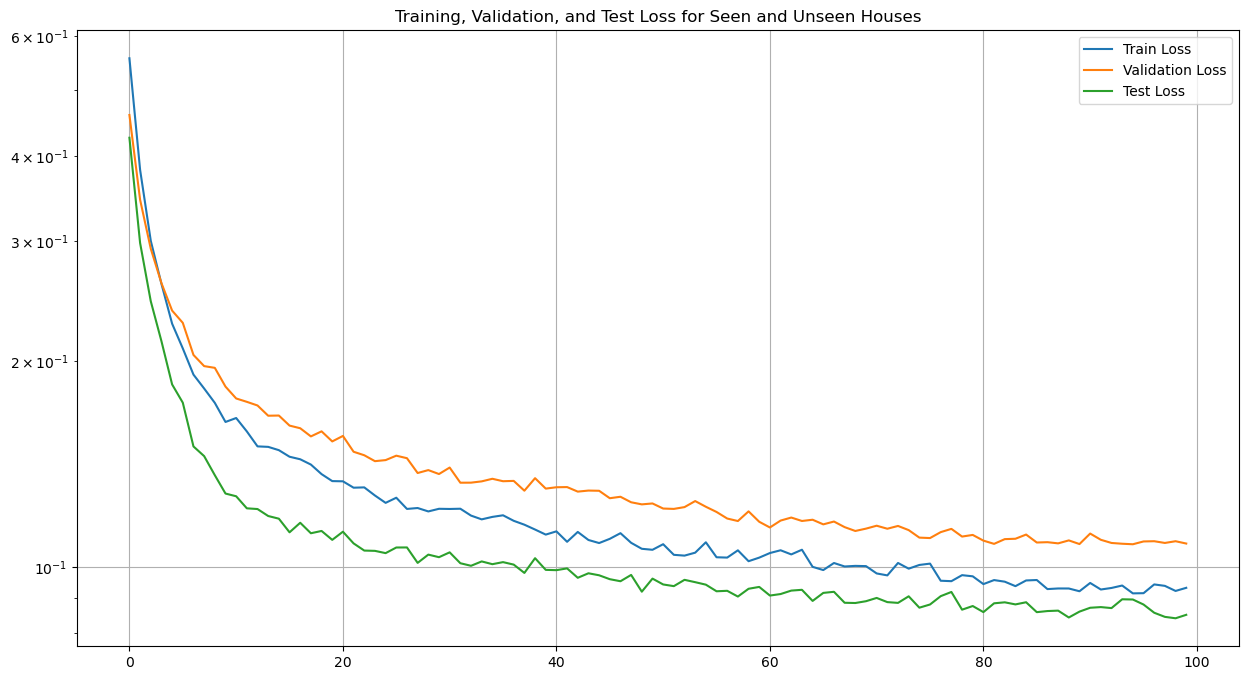

Final model weights saved to UKDALE_final_model_weights.pth
Evaluating fridge model
Loading model from UKDALE_seen_model_1.pth


NameError: name 'evaluate_activation' is not defined

In [14]:

# Unseen data training and validation
train_loader = dl_train_unseen
valid_loader = dl_valid_unseen
test_loader = dl_test_unseen
n_epochs = 100
for i in range(20):
    print('TRAINING MODEL for unseen house %d' % (i + 2))
    model = PTPNet(1, 3, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    model_filename = f'UKDALE_unseen_model_{i+2}.pth'
    model, train_loss, valid_loss, test_loss = train_model(model, batch_size, n_epochs, model_filename)
    print(f"Model {i+2} trained for unseen data.")

# Plot the training and validation loss for seen and unseen houses
plt.figure(figsize=(15, 8))
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.plot(test_loss, label='Test Loss')
plt.yscale('log')
plt.title('Training, Validation, and Test Loss for Seen and Unseen Houses')
plt.legend()
plt.grid(True)
plt.show()

# Save the final model weights after training is completed
final_model_weights_path = 'UKDALE_final_model_weights.pth'
torch.save(model.state_dict(), final_model_weights_path)
print(f"Final model weights saved to {final_model_weights_path}")



In [17]:
model = PTPNet(1,3,32).to('cpu')
model.eval()

PTPNet(
  (encoder1): Encoder(
    (conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Encoder(
    (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder3): Encoder(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), bias=False)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop): Dropout(p=0.1, inplace=False)
  )
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder4): Encoder(
    (conv): Conv1d(128,

In [18]:
scores = {}
for a in range(3):
    scores[a] = {}
    scores[a]['F1'] = []
    scores[a]['Precision'] = []
    scores[a]['Recall'] = []
    scores[a]['Accuracy'] = []
    scores[a]['MCC'] = []
    scores[a]['MAE'] = []
    scores[a]['SAE'] = []

thr = 0.5
predicted_consumptions = {appliance: [] for appliance in APPLIANCE}
for i in range(20):
    
    filename = './UKDALE_seen_%d.pth' %i
    print(filename)
    model.load_state_dict(torch.load(filename))
    for a in range(3):
        appliance_name = APPLIANCE[a]
        pm = ds_appliance[0][APPLIANCE[a]].sum() / ds_status[0][APPLIANCE[a]].sum() / MAX_POWER
        x_true, p_true, s_true, s_hat = evaluate_activation(model, dl_house_test[0], a)
        s_hat = get_status(s_hat, thr, MIN_OFF[a], MIN_ON[a])
        p_hat = pm * s_hat
        scores[a]['F1'].append(f1_score(s_true, s_hat))
        scores[a]['Precision'].append(precision_score(s_true, s_hat))
        scores[a]['Recall'].append(recall_score(s_true, s_hat))
        scores[a]['Accuracy'].append(accuracy_score(s_true, s_hat))
        scores[a]['MCC'].append(matthews_corrcoef(s_true, s_hat))
        scores[a]['MAE'].append(mean_absolute_error(p_true, p_hat)*MAX_POWER)
        scores[a]['SAE'].append((p_hat.sum() - p_true.sum()) / p_true.sum())
        # Collect predicted consumptions
        predicted_consumptions[appliance_name].extend(p_hat.tolist())
# Retrieve timestamps from the dataset
timestamps = ds_meter[0].index.tolist()

# Truncate data to match the shortest sequence length
min_length = min(len(timestamps), *[len(predicted_consumptions[appliance]) for appliance in APPLIANCE])
timestamps = timestamps[:min_length]
for appliance in predicted_consumptions:
    predicted_consumptions[appliance] = predicted_consumptions[appliance][:min_length]

# Save predictions and timestamps for each appliance to CSV
for appliance in APPLIANCE:
    df = pd.DataFrame({
        'timestamps': timestamps,
        'predicted_consumption': predicted_consumptions[appliance]
    })
    output_file = f'{appliance}_predicted_consumptions.csv'
    df.to_csv(output_file, index=False)
    
for i,a in enumerate(APPLIANCE):
    print()
    print(a)
    print('F1 score  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['F1']), sorted(scores[i]['F1'])[1], sorted(scores[i]['F1'])[18]))
    print('Precision : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Precision']), sorted(scores[i]['Precision'])[1], sorted(scores[i]['Precision'])[18]))
    print('Recall    : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Recall']), sorted(scores[i]['Recall'])[1], sorted(scores[i]['Recall'])[18]))
    print('Accuracy  : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['Accuracy']), sorted(scores[i]['Accuracy'])[1], sorted(scores[i]['Accuracy'])[18]))
    print('MCC       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['MCC']), sorted(scores[i]['MCC'])[1], sorted(scores[i]['MCC'])[18]))
    print('MAE       : %.2f (%.2f, %.2f)' %(np.mean(scores[i]['MAE']), sorted(scores[i]['MAE'])[1], sorted(scores[i]['MAE'])[18]))
    print('SAE       : %.3f (%.3f, %.3f)' %(np.mean(scores[i]['SAE']), sorted(scores[i]['SAE'])[1], sorted(scores[i]['SAE'])[18]))

./UKDALE_seen_0.pth
./UKDALE_seen_1.pth
./UKDALE_seen_2.pth
./UKDALE_seen_3.pth
./UKDALE_seen_4.pth
./UKDALE_seen_5.pth
./UKDALE_seen_6.pth
./UKDALE_seen_7.pth
./UKDALE_seen_8.pth
./UKDALE_seen_9.pth
./UKDALE_seen_10.pth
./UKDALE_seen_11.pth
./UKDALE_seen_12.pth
./UKDALE_seen_13.pth
./UKDALE_seen_14.pth
./UKDALE_seen_15.pth
./UKDALE_seen_16.pth
./UKDALE_seen_17.pth
./UKDALE_seen_18.pth
./UKDALE_seen_19.pth

fridge
F1 score  : 0.838 (0.835, 0.841)
Precision : 0.847 (0.839, 0.856)
Recall    : 0.828 (0.820, 0.841)
Accuracy  : 0.854 (0.851, 0.857)
MCC       : 0.706 (0.699, 0.712)
MAE       : 17.50 (17.23, 17.77)
SAE       : -0.025 (-0.043, -0.003)

dish_washer
F1 score  : 0.907 (0.879, 0.933)
Precision : 0.922 (0.890, 0.947)
Recall    : 0.893 (0.848, 0.945)
Accuracy  : 0.996 (0.994, 0.997)
MCC       : 0.905 (0.876, 0.932)
MAE       : 20.64 (20.05, 21.25)
SAE       : -0.048 (-0.114, 0.006)

washing_machine
F1 score  : 0.971 (0.963, 0.976)
Precision : 0.963 (0.948, 0.973)
Recall    : 0.980 (